# Live Coding: Reducción Dimensional Avanzada y Feature Engineering
## PCA vs UMAP vs t-SNE - Análisis Comparativo

**Duración:** 90 minutos  
**Dataset:** Mice Protein Expression (UCI ML Repository)  
**Objetivo:** Comparar técnicas de reducción dimensional con feature engineering avanzado

### Agenda:
1. **[15 min]** Exploración y Feature Engineering
2. **[20 min]** PCA: Análisis de componentes principales
3. **[20 min]** t-SNE: Preservación de estructura local
4. **[20 min]** UMAP: Balance entre local y global
5. **[15 min]** Comparación cuantitativa y conclusiones

In [1]:
# Instalación de dependencias
!pip install umap-learn pandas numpy scikit-learn matplotlib seaborn plotly scipy openpyxl -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import umap

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

---
## 1. Carga y Exploración del Dataset

**Mice Protein Expression Dataset:**
- 1080 muestras de expresión de proteínas en ratones
- 77 proteínas medidas
- 8 clases (diferentes condiciones experimentales)
- Datos con valores faltantes y outliers

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls'
df = pd.read_excel(url)

print(f"Shape: {df.shape}")
print(f"\nClases: {df['class'].unique()}")
df.head()

Shape: (1080, 82)

Clases: ['c-CS-m' 'c-SC-m' 'c-CS-s' 'c-SC-s' 't-CS-m' 't-SC-m' 't-CS-s' 't-SC-s']


,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


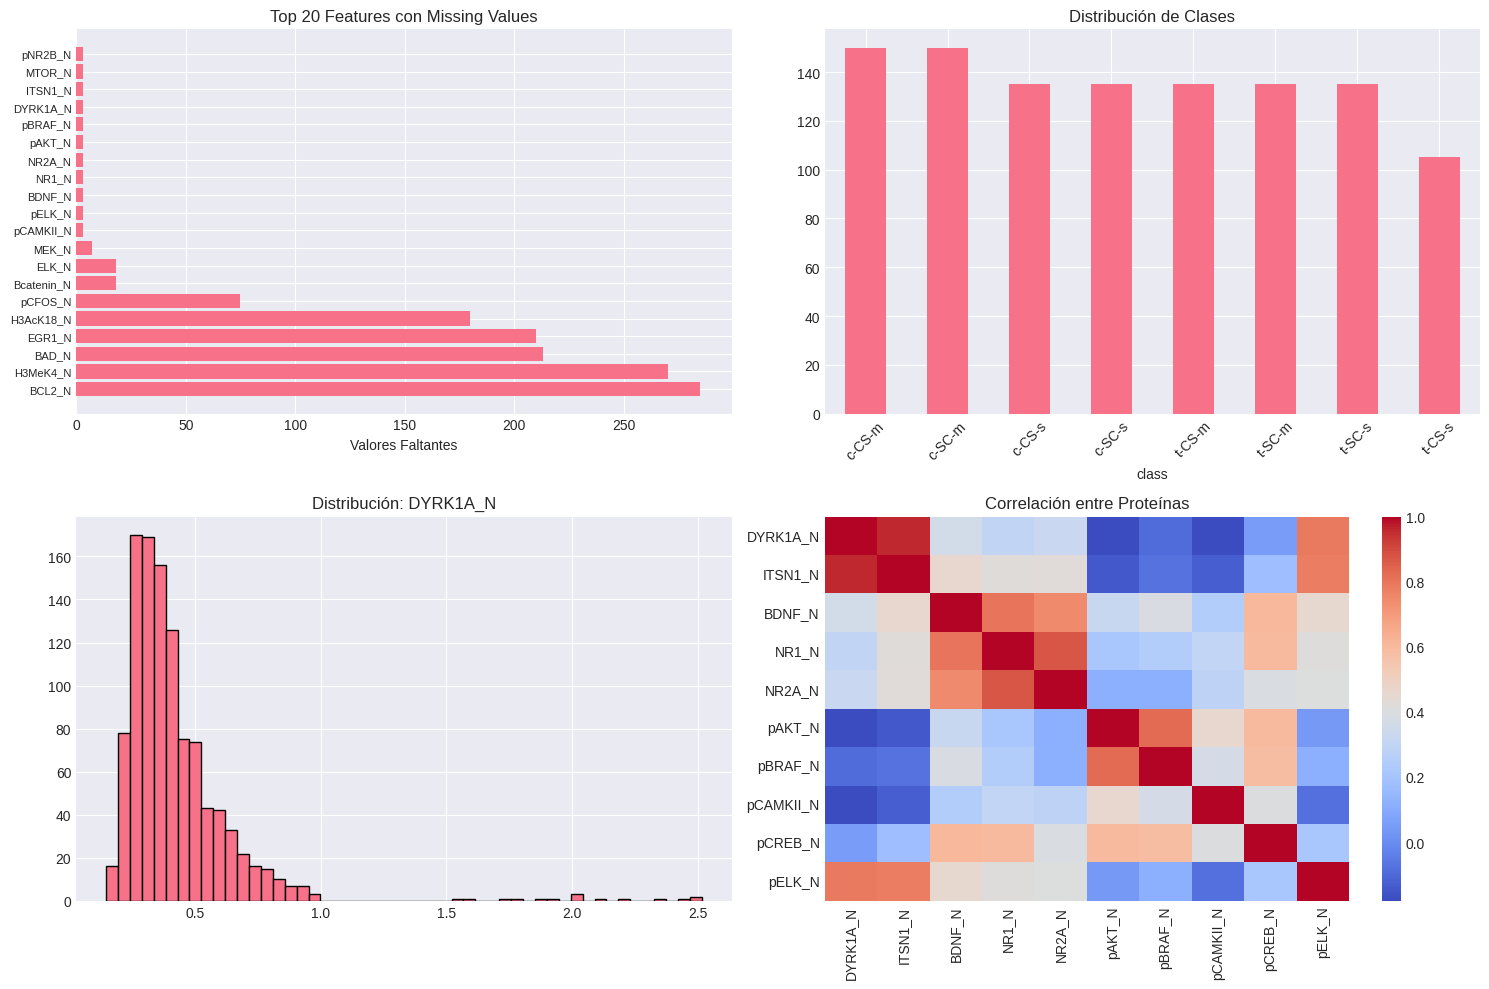

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

missing = df.isnull().sum().sort_values(ascending=False).head(20)
axes[0, 0].barh(range(len(missing)), missing.values)
axes[0, 0].set_yticks(range(len(missing)))
axes[0, 0].set_yticklabels(missing.index, fontsize=8)
axes[0, 0].set_xlabel('Valores Faltantes')
axes[0, 0].set_title('Top 20 Features con Missing Values')

df['class'].value_counts().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de Clases')
axes[0, 1].tick_params(axis='x', rotation=45)

protein_cols = df.select_dtypes(include=[np.number]).columns
axes[1, 0].hist(df[protein_cols[0]].dropna(), bins=50, edgecolor='black')
axes[1, 0].set_title(f'Distribución: {protein_cols[0]}')

corr_matrix = df[protein_cols[:10]].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Correlación entre Proteínas')

plt.tight_layout()
plt.show()

---
## 2. Feature Engineering Avanzado

In [5]:
protein_cols = [col for col in df.columns if '_N' in col]
X = df[protein_cols].copy()
y = df['class'].copy()

print(f"Features originales: {X.shape[1]}")
print(f"Muestras: {X.shape[0]}")

Features originales: 77
Muestras: 1080


In [6]:
from sklearn.impute import KNNImputer

missing_pct = X.isnull().sum() / len(X)
high_missing_cols = missing_pct[missing_pct > 0.3].index
low_missing_cols = missing_pct[(missing_pct > 0) & (missing_pct <= 0.3)].index

if len(low_missing_cols) > 0:
    imputer_knn = KNNImputer(n_neighbors=5, weights='distance')
    X[low_missing_cols] = imputer_knn.fit_transform(X[low_missing_cols])

if len(high_missing_cols) > 0:
    X[high_missing_cols] = X[high_missing_cols].fillna(X[high_missing_cols].median())

print(f"✅ Missing values: {X.isnull().sum().sum()}")

✅ Missing values: 0


In [7]:
X_clean = X.copy()
for col in X.columns:
    p01 = X[col].quantile(0.01)
    p99 = X[col].quantile(0.99)
    X_clean[col] = X[col].clip(lower=p01, upper=p99)

print("✅ Outliers tratados con winsorización")

✅ Outliers tratados con winsorización


In [8]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_transformed = pd.DataFrame(
    pt.fit_transform(X_clean),
    columns=X_clean.columns,
    index=X_clean.index
)

print("✅ Transformación Yeo-Johnson aplicada")

✅ Transformación Yeo-Johnson aplicada


In [9]:
X_engineered = X_transformed.copy()

X_engineered['mean_expression'] = X_transformed.mean(axis=1)
X_engineered['std_expression'] = X_transformed.std(axis=1)
X_engineered['max_expression'] = X_transformed.max(axis=1)
X_engineered['min_expression'] = X_transformed.min(axis=1)
X_engineered['range_expression'] = X_engineered['max_expression'] - X_engineered['min_expression']
X_engineered['cv_expression'] = X_engineered['std_expression'] / (X_engineered['mean_expression'] + 1e-10)
X_engineered['skew_expression'] = X_transformed.skew(axis=1)
X_engineered['kurtosis_expression'] = X_transformed.kurtosis(axis=1)

X_engineered['q25_expression'] = X_transformed.quantile(0.25, axis=1)
X_engineered['q75_expression'] = X_transformed.quantile(0.75, axis=1)
X_engineered['iqr_expression'] = X_engineered['q75_expression'] - X_engineered['q25_expression']

corr_matrix = X_transformed.corr()
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

for idx, (col1, col2) in enumerate(high_corr_pairs[:10]):
    X_engineered[f'ratio_{idx}'] = X_transformed[col1] / (X_transformed[col2] + 1e-10)
    X_engineered[f'product_{idx}'] = X_transformed[col1] * X_transformed[col2]

print(f"✅ Features creados: {X_engineered.shape[1] - X_transformed.shape[1]}")
print(f"📊 Total features: {X_engineered.shape[1]}")

✅ Features creados: 31
📊 Total features: 108


In [10]:
scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_engineered),
    columns=X_engineered.columns,
    index=X_engineered.index
)

print(f"✅ Dataset preparado: {X_scaled.shape}")

✅ Dataset preparado: (1080, 108)


---
## 3. PCA: Principal Component Analysis

Componentes para 90% varianza: 17


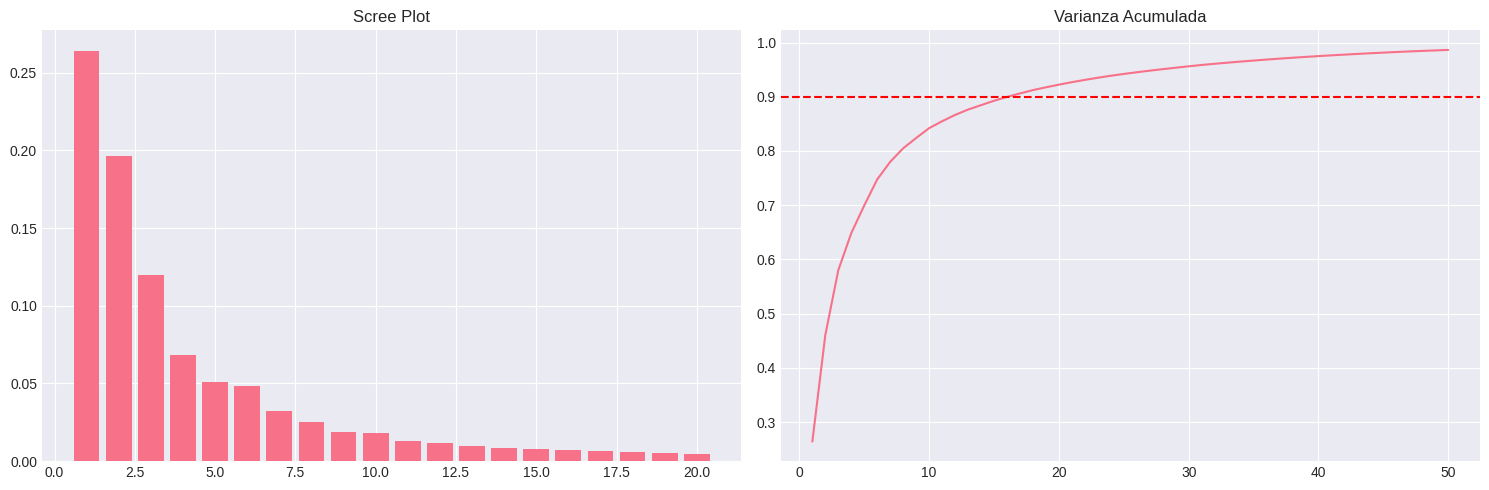

In [11]:
pca = PCA(n_components=50)
X_pca_full = pca.fit_transform(X_scaled)

cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1

print(f"Componentes para 90% varianza: {n_components_90}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(range(1, 21), pca.explained_variance_ratio_[:20])
axes[0].set_title('Scree Plot')

axes[1].plot(range(1, 51), cumsum_variance)
axes[1].axhline(y=0.90, color='r', linestyle='--')
axes[1].set_title('Varianza Acumulada')

plt.tight_layout()
plt.show()

In [12]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

df_pca = pd.DataFrame({
    'PC1': X_pca_2d[:, 0],
    'PC2': X_pca_2d[:, 1],
    'class': y
})

fig = px.scatter(
    df_pca, x='PC1', y='PC2', color='class',
    title=f'PCA 2D - Varianza: {sum(pca_2d.explained_variance_ratio_)*100:.2f}%',
    width=900, height=600
)
fig.show()

---
## 4. t-SNE: t-Distributed Stochastic Neighbor Embedding

In [13]:
perplexities = [5, 30, 50, 100]
tsne_results = {}

for perp in perplexities:
    print(f"t-SNE perplexity={perp}...")
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42, n_iter=1000)
    tsne_results[perp] = tsne.fit_transform(X_scaled)

print("✅ t-SNE completado")

t-SNE perplexity=5...
t-SNE perplexity=30...
t-SNE perplexity=50...
t-SNE perplexity=100...
✅ t-SNE completado


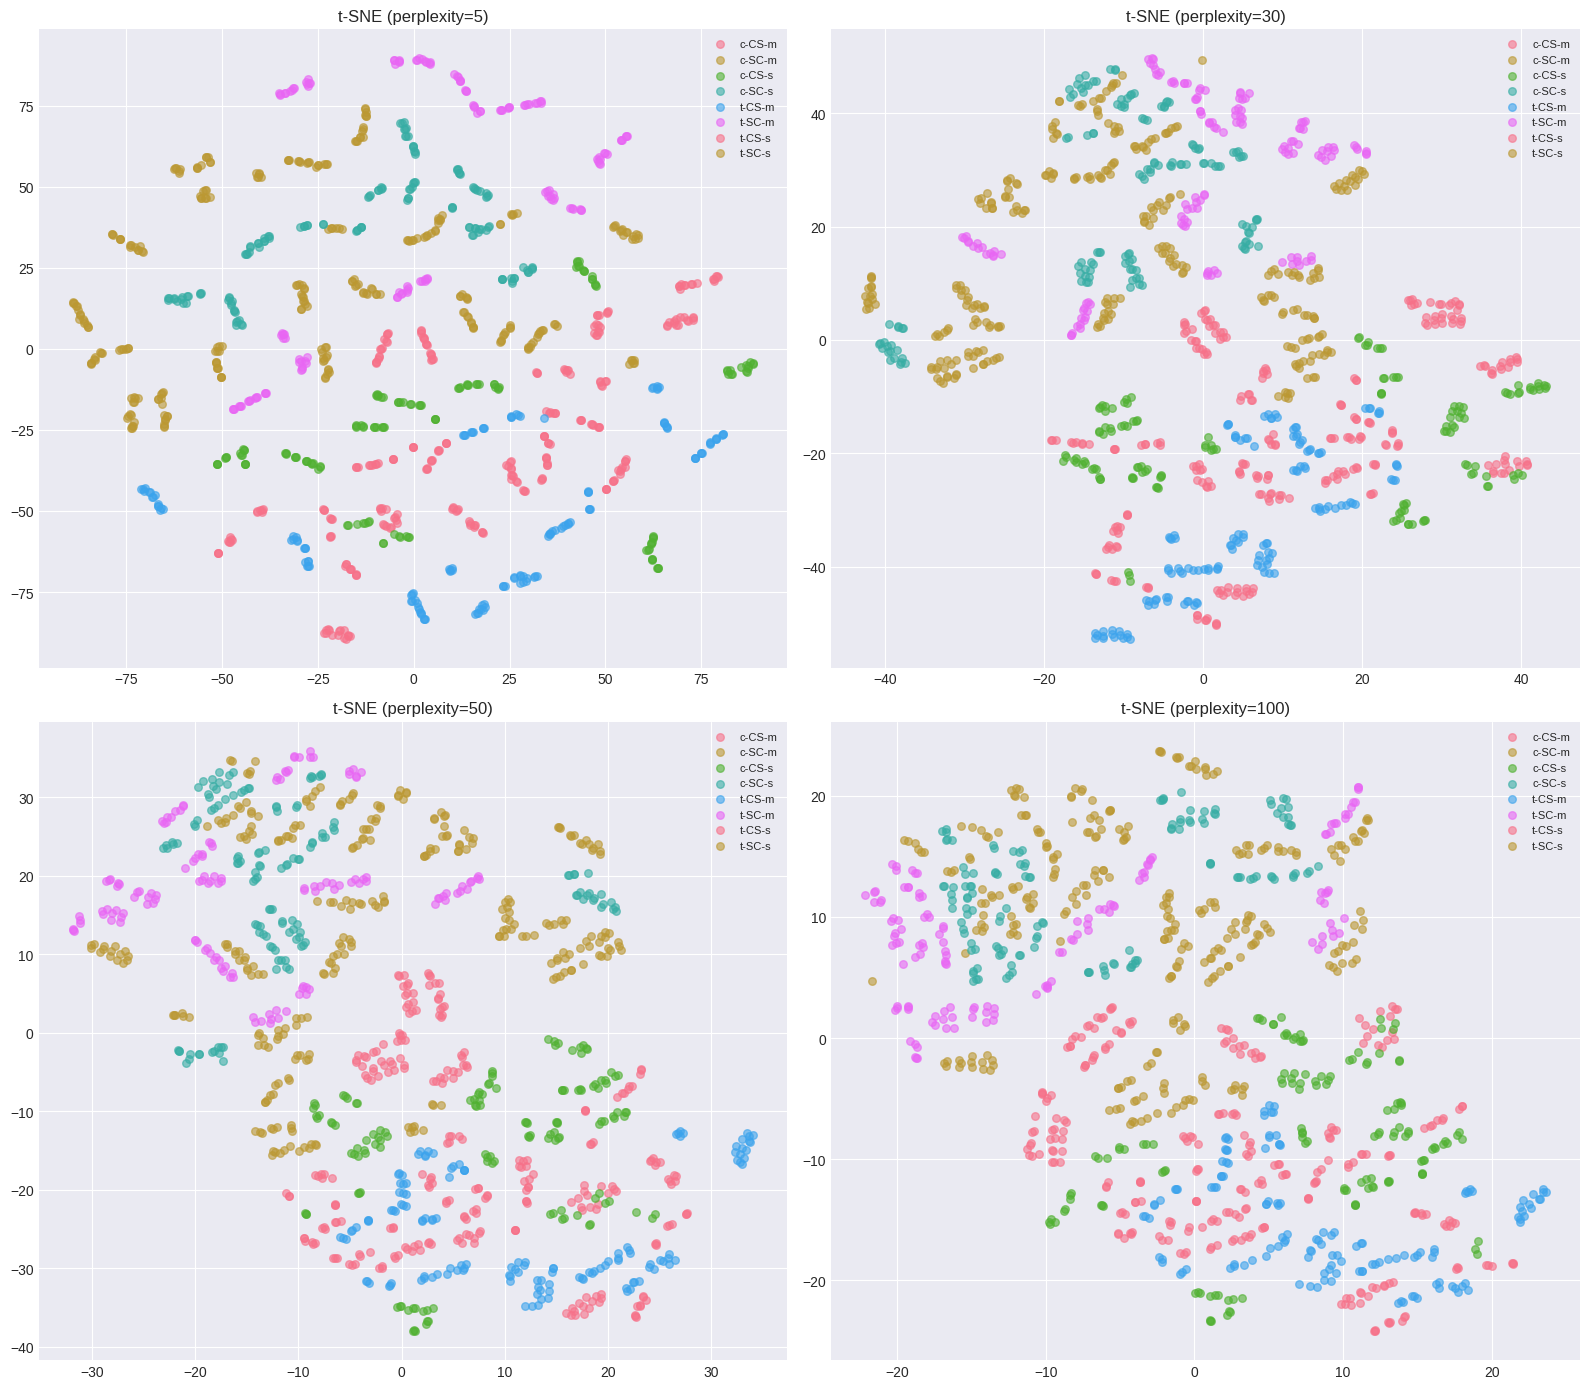

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, perp in enumerate(perplexities):
    X_tsne = tsne_results[perp]
    for class_name in y.unique():
        mask = y == class_name
        axes[idx].scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=class_name, alpha=0.6, s=30)
    axes[idx].set_title(f't-SNE (perplexity={perp})')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

---
## 5. UMAP: Uniform Manifold Approximation and Projection

In [15]:
n_neighbors_list = [5, 15, 30, 50]
umap_results = {}

for n_neigh in n_neighbors_list:
    print(f"UMAP n_neighbors={n_neigh}...")
    reducer = umap.UMAP(n_neighbors=n_neigh, min_dist=0.1, random_state=42)
    umap_results[n_neigh] = reducer.fit_transform(X_scaled)

print("✅ UMAP completado")

UMAP n_neighbors=5...
UMAP n_neighbors=15...
UMAP n_neighbors=30...
UMAP n_neighbors=50...
✅ UMAP completado


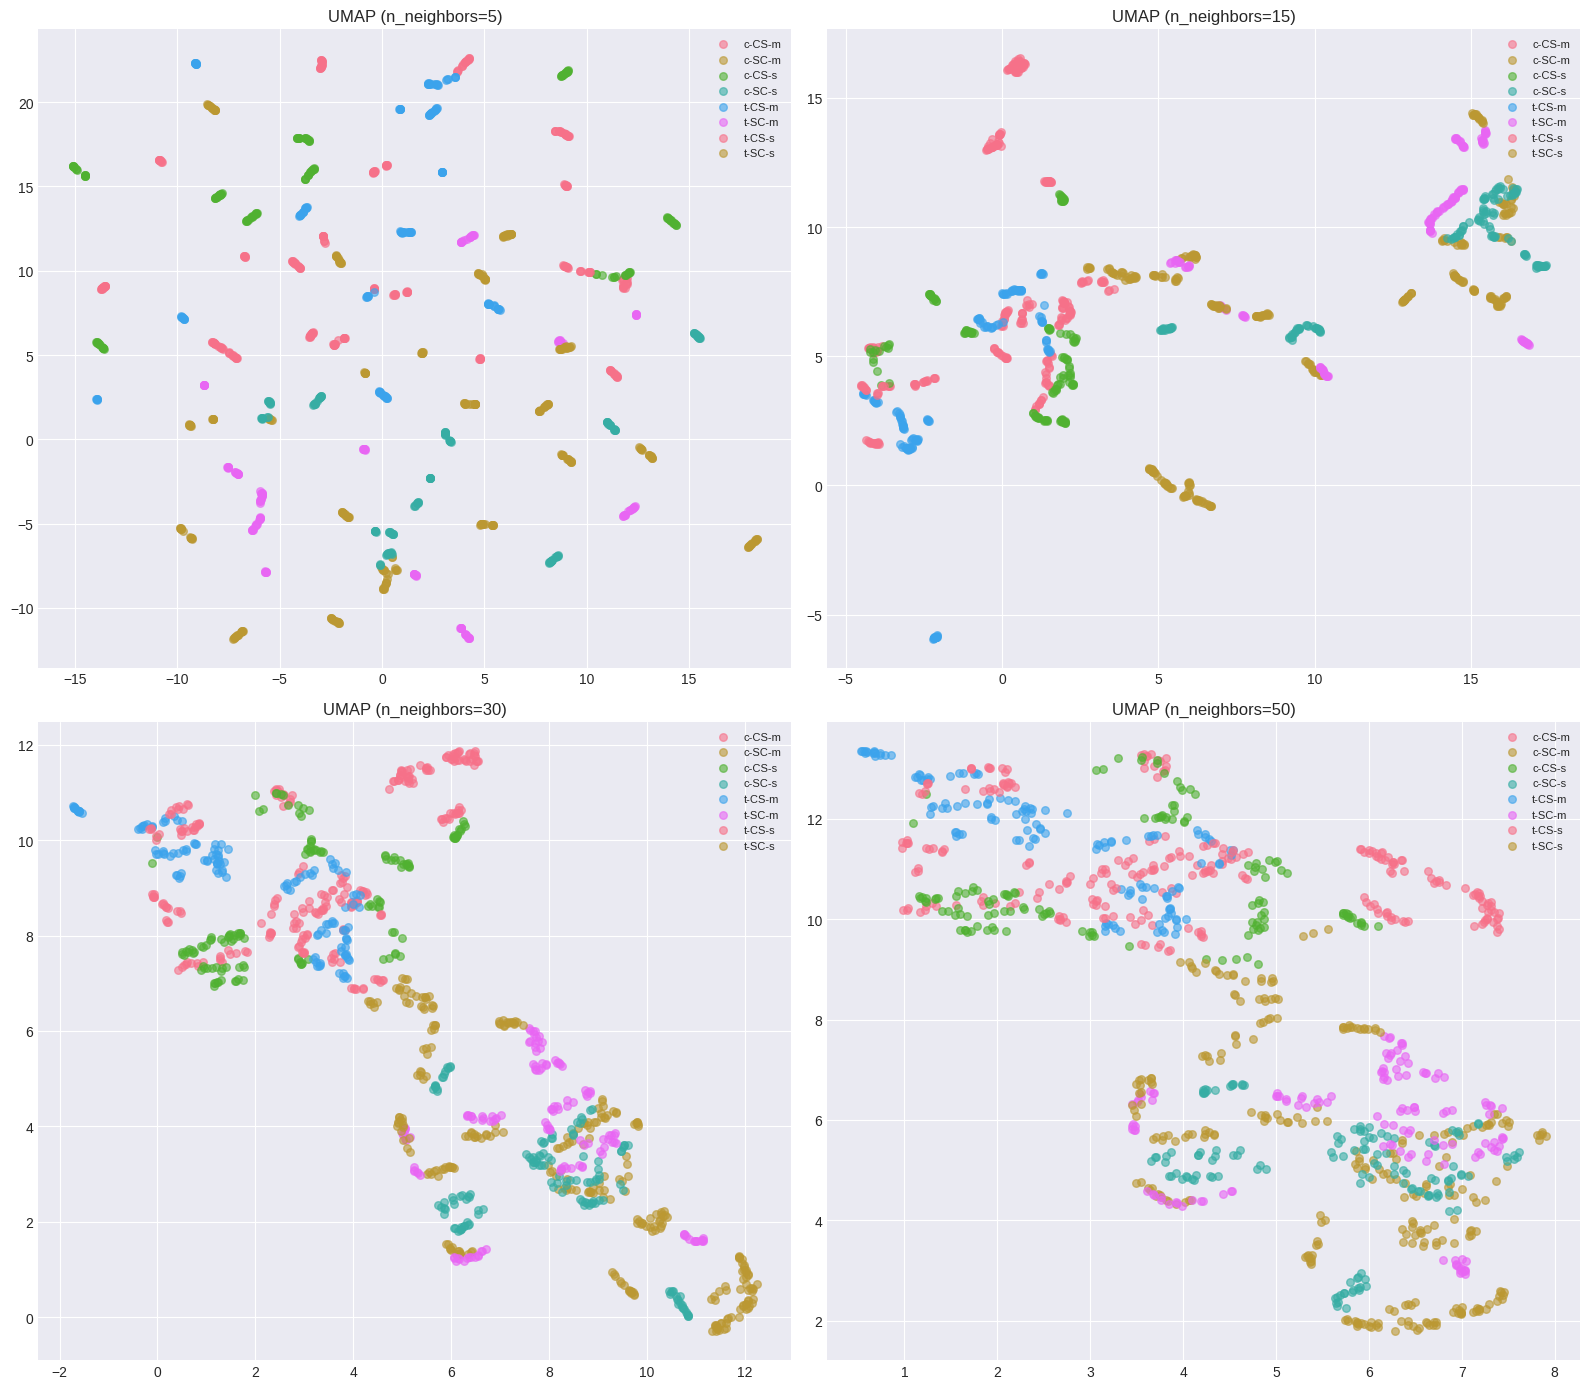

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, n_neigh in enumerate(n_neighbors_list):
    X_umap = umap_results[n_neigh]
    for class_name in y.unique():
        mask = y == class_name
        axes[idx].scatter(X_umap[mask, 0], X_umap[mask, 1], label=class_name, alpha=0.6, s=30)
    axes[idx].set_title(f'UMAP (n_neighbors={n_neigh})')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

---
## 6. Comparación Cuantitativa

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

results = []

results.append({
    'Method': 'PCA',
    'Silhouette': silhouette_score(X_pca_2d, y_encoded),
    'Calinski-Harabasz': calinski_harabasz_score(X_pca_2d, y_encoded),
    'Davies-Bouldin': davies_bouldin_score(X_pca_2d, y_encoded)
})

results.append({
    'Method': 't-SNE (perp=30)',
    'Silhouette': silhouette_score(tsne_results[30], y_encoded),
    'Calinski-Harabasz': calinski_harabasz_score(tsne_results[30], y_encoded),
    'Davies-Bouldin': davies_bouldin_score(tsne_results[30], y_encoded)
})

results.append({
    'Method': 'UMAP (n=15)',
    'Silhouette': silhouette_score(umap_results[15], y_encoded),
    'Calinski-Harabasz': calinski_harabasz_score(umap_results[15], y_encoded),
    'Davies-Bouldin': davies_bouldin_score(umap_results[15], y_encoded)
})

df_results = pd.DataFrame(results)
print("\n📊 MÉTRICAS DE CLUSTERING:")
print(df_results.to_string(index=False))
print("\nNota: Silhouette y Calinski-Harabasz → más alto es mejor")
print("      Davies-Bouldin → más bajo es mejor")


📊 MÉTRICAS DE CLUSTERING:
         Method  Silhouette  Calinski-Harabasz  Davies-Bouldin
            PCA   -0.065397          91.367540        7.202275
t-SNE (perp=30)   -0.006887         231.619019        5.287788
    UMAP (n=15)   -0.004744         313.535431        6.076380

Nota: Silhouette y Calinski-Harabasz → más alto es mejor
      Davies-Bouldin → más bajo es mejor


In [18]:
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('PCA', 't-SNE (perp=30)', 'UMAP (n=15)')
)

for class_name in y.unique():
    mask = y == class_name
    fig.add_trace(
        go.Scatter(x=X_pca_2d[mask, 0], y=X_pca_2d[mask, 1], mode='markers',
                   name=class_name, marker=dict(size=5, opacity=0.6)),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=tsne_results[30][mask, 0], y=tsne_results[30][mask, 1], mode='markers',
                   name=class_name, marker=dict(size=5, opacity=0.6), showlegend=False),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=umap_results[15][mask, 0], y=umap_results[15][mask, 1], mode='markers',
                   name=class_name, marker=dict(size=5, opacity=0.6), showlegend=False),
        row=1, col=3
    )

fig.update_layout(height=500, width=1400, title_text="Comparación: PCA vs t-SNE vs UMAP")
fig.show()

---
## 7. Conclusiones y Recomendaciones

### Cuándo usar cada técnica:

**PCA:**
- Análisis exploratorio rápido
- Reducción de dimensionalidad para ML
- Interpretabilidad de componentes
- Datasets con relaciones lineales

**t-SNE:**
- Visualización de clusters
- Exploración de estructura local
- Presentaciones y papers
- ⚠️ NO para reducción dimensional en pipelines ML

**UMAP:**
- Balance entre local y global
- Más rápido que t-SNE
- Mejor preservación de estructura
- Puede usarse en pipelines ML